In [27]:
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import requests
!pip install geocoder
import geocoder

In [28]:
link = " https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = requests.get(link)
soup = BeautifulSoup(page.content, 'html.parser')

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [29]:
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


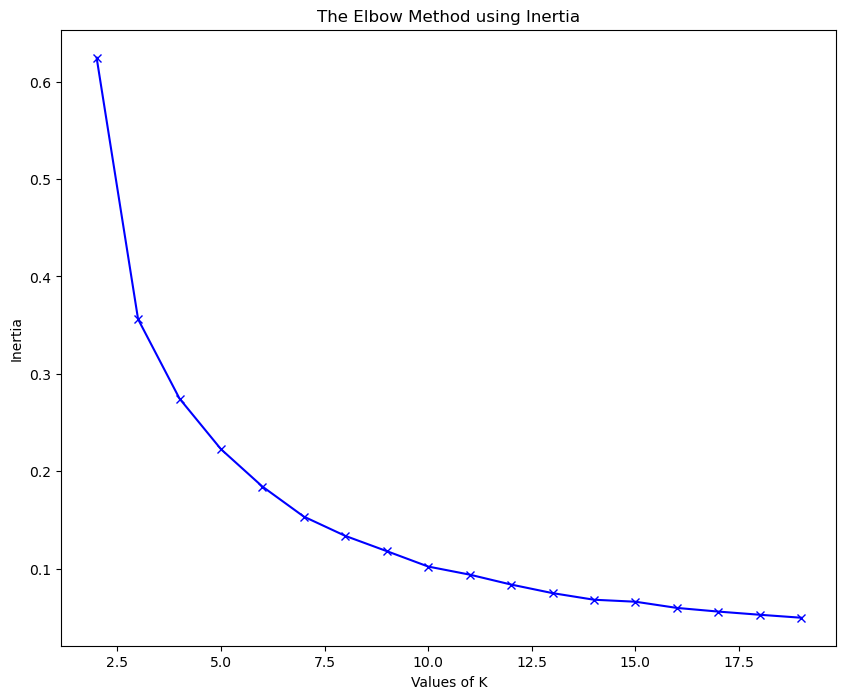

In [30]:
X = df.drop(['PostalCode','Borough','Neighborhood'], axis=1)
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
plt.figure(figsize=[10, 8])
inertia=[]
range_val=range(2,20)
for i in range_val:
  kmean=KMeans(n_clusters=i)
  kmean.fit_predict(X)
  inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

In [31]:
k=4
kmeans = KMeans(n_clusters = k,random_state=0).fit(X)
kmeans.labels_
df.insert(0, 'Cluster Labels', kmeans.labels_)
df.head()

,Cluster Labels,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,3,M3A,North York,Parkwoods,43.753259,-79.329656
1,3,M4A,North York,Victoria Village,43.725882,-79.315572
2,0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,0,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [32]:
lat_toronto = df['Latitude'].mean()
lon_toronto = df['Longitude'].mean()
import folium
map_clusters = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, neighbourhood, cluster in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters